# Training a Multilabel CNN for ECG Classification

<a href='https://link.springer.com/chapter/10.1007/978-3-031-66535-6_30#Tab1'>Link To Article</a>

In [1]:
import os
import keras
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential # type: ignore
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, GlobalAveragePooling1D, BatchNormalization, Activation # type: ignore

In [16]:
# Importing user-defined module
from Scripts.ptbxl_ml import *

### Checking For Available GPUs:

In [17]:
gpus = tf.config.list_physical_devices('GPU')

In [18]:
if gpus:
    for gpu in gpus:
        print(f'GPU Name: {gpu.name}')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs, ', len(logical_gpus), 'Logical GPUs')

else:
    print('No GPUs found')

No GPUs found


### Loading Preprocessed PTB-XL Dataset:

In [19]:
npz_file = r'C:\Users\loera\OneDrive\Python Projects\College\ECG\Processed Datasets\ML_dataset.npz'

In [20]:
ptbxl_df, signals_df = load_database(npz_file)

### Splitting Data into Training and Testing Sets:

In [ ]:
# Formatting signals and superclassses to numpy arrays
signals = signals_df.to_numpy(dtype=float)
superclasses = ptbxl_df.loc[:,'superclasses'].to_numpy(dtype=list)

In [22]:
# Assigns data (signals) to X
X = signals

# Assigns labels (superclasses) to Y
Y = superclasses

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [24]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(17110, 5000) (17110,)
(4278, 5000) (4278,)


<h3>Counting Instances of each Superclass:</h3>

In [25]:
from collections import Counter

str_y_train = [str(x) for x in y_train]

counter = Counter(str_y_train)

for label, num in counter.items():
    print(f'{label}: {num}')

['CD', 'HYP', 'STTC']: 160
['CD', 'STTC']: 376
['STTC']: 1904
['CD', 'NORM']: 331
['MI', 'STTC']: 473
['CD']: 1360
['NORM']: 7281
['MI']: 2044
['CD', 'MI', 'STTC']: 173
['HYP']: 418
['CD', 'MI']: 1032
['HYP', 'MI', 'STTC']: 289
['HYP', 'STTC']: 628
['CD', 'HYP', 'MI', 'STTC']: 131
['HYP', 'MI']: 146
['NORM', 'STTC']: 24
['CD', 'HYP', 'MI']: 94
['CD', 'HYP']: 236
['CD', 'NORM', 'STTC']: 5
['HYP', 'NORM']: 2
['CD', 'HYP', 'NORM']: 2
['CD', 'HYP', 'MI', 'NORM']: 1


<h3>Converting Labels/Superclasses into Binary Matrix Format:</h3>

In [26]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)

In [27]:
# Showing original versus encoded labels
print('Classes:', mlb.classes_)

print('\nEncoded Training Labels:\n', y_train[:5])
print('\nOriginal Training Labels:\n', mlb.inverse_transform(y_train[:5]))

print('\nEncoded Testing Labels:\n', y_test[:5])
print('\nOriginal Testing Labels:\n', mlb.inverse_transform(y_test[:5]))

Classes: ['CD' 'HYP' 'MI' 'NORM' 'STTC']

Encoded Training Labels:
 [[1 1 0 0 1]
 [1 0 0 0 1]
 [0 0 0 0 1]
 [1 0 0 1 0]
 [0 0 1 0 1]]

Original Training Labels:
 [('CD', 'HYP', 'STTC'), ('CD', 'STTC'), ('STTC',), ('CD', 'NORM'), ('MI', 'STTC')]

Encoded Testing Labels:
 [[0 0 0 1 0]
 [0 0 0 1 0]
 [1 0 1 0 0]
 [0 0 1 0 1]
 [0 0 1 0 0]]

Original Testing Labels:
 [('NORM',), ('NORM',), ('CD', 'MI'), ('MI', 'STTC'), ('MI',)]


In [28]:
print(y_train.shape, y_test.shape)

(17110, 5) (4278, 5)


<h3>Defining How to Plot Graphs:</h3>

In [29]:
def plot_graphs(history) -> None:
    '''
    Plots 3 graphs using a sequential model's history: Training vs. Validation Loss, Training vs. Validation Accuracy,
    and Training vs. Validation AUC.
    
    Args:
        history: A history object (i.e., a record of training and validation metrics)
    
    Returns:
        None:
    '''
    # Plots training loss versus validation loss
    plt.plot(history.epoch, history.history['loss'], 'b', label='Training Loss')
    plt.plot(history.epoch, history.history['val_loss'], 'g', label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()
    
    # Plots training accuracy versus validation accuracy
    plt.plot(history.epoch, history.history['Accuracy'], 'b', label='Training Accuracy')
    plt.plot(history.epoch, history.history['val_Accuracy'], 'g', label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()
    
    # Plots training area under curve versus validation area under curve
    plt.plot(history.epoch, history.history['AUC'], 'b', label='Training AUC')
    plt.plot(history.epoch, history.history['val_AUC'], 'g', label='Validation AUC')
    plt.legend()
    plt.title('AUC')
    plt.show()

<h3>Defining Functions for Evaluating the Model:</h3>

In [30]:
def evaluate_model(model: keras.Sequential, test_data: np.ndarray, test_labels: np.ndarray) -> list[float]:
    '''
    Evaluates a pre-trained model on the test data provided.
    
    Args:
        model: The pre-trained model to be evaluated
        test_data: A matrix of shape (n_samples, n_time_points)
        test_labels: The labels corresponding the the test/validation dataset
        
    Returns:
        tuple: A two-element tuple, containing the model's loss and accuracy scores
    '''
    score = model.evaluate(test_data, test_labels, verbose=1)
    
    print(f'\nLoss on test data: {score[0]:.2f}')
    print(f'\nAccuracy on test data: {score[1]:.2f}')
    
    return score

In [31]:
def model_predict(model: keras.Sequential, test_data: np.ndarray, test_labels: np.ndarray, threshold: float=0.5) -> tuple[np.ndarray, np.ndarray]:
    '''
    Generates predictions using the inputted model and test data. The threshold specified will determine if a certain 
    superclass/label is present within a record.
    
    Args:
        model: The pre-trained model that will be generating the predictions
        test_data: A matrix of shape: (n_samples, n_time_points)
        test_labels: The labels corresponding to the test/validation dataset
        threshold: Determines the minimum value for considering a superclass present
        
    Returns:
        tuple: A two-element tuple containng the ground truth labels and the model's predicted labels
    '''
    y_test_pred = model.predict(test_data)
    
    # Converts probabilites into binary labels (i.e. either 0 or 1 if they meet the threshold)
    y_hat = (y_test_pred >= threshold).astype(int)
    
    # Ensures test data is in binary format
    y_test = test_labels.astype(int)
    
    return (y_test, y_hat)

In [32]:
def show_confusion_matrix(test_labels: np.ndarray, prediction_labels: np.ndarray, classes: np.ndarray) -> list:
    '''
    Visualizes the performance of a model via confusion matrices and heatmaps. A 2x2 confusion matrix is plotted and 
    displayed for each class.
    
    Args:
        test_labels: The ground truth labels
        prediction_labels: The generated labels predicted by a pre-trained model
        classes: The labels of the unique superclasses within the dataset (i.e., [CD, HYP, MI, NORM, STTC])
    
    Returns:
        list: A list containing figures corresponding to each superclass
    '''
    figures = []
    
    # Computes the confusion matrix for each individual class
    matrices = multilabel_confusion_matrix(test_labels, prediction_labels)
    
    for i, label in enumerate(classes):
        
        plt.figure(figsize=(6,4))
        
        sns_hm = sns.heatmap(matrices[i],
                            cmap='YlGnBu',
                            linecolor='white',
                            xticklabels=['Negative', 'Positive'],
                            yticklabels=['Negative', 'Positive'],
                            annot=True, # ensures values are on heatmap
                            fmt='d') # formats values as ints
        
        plt.title(f'{label} Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        figure = sns_hm.get_figure()
        figures.append(figure)
        plt.show()
        
    return figures

<h3>Generating the CNN Model:</h3>

In [33]:
def generate_1D_model() -> keras.Sequential:
    '''
    Generates and returns a Keras sequential CNN model with 7 convolutional blocks. The initial 6 blocks consist of 1D 
    convolutional layers with ReLU activation, batch normalization, max pooling, and dropout layers. The final block
    implements a 1D convolutional layer, however, it performs global average pooling and has a larger droput value.
    
    Args:
        None:
        
    Returns:
        keras.Sequential: The model generated
    '''
    model = Sequential([Input(shape=(5000,1))])
    
    # Convolutional Block 1
    model.add(Conv1D(32, 3, name='conv1', input_shape=(5000,1)))
    model.add(BatchNormalization(name='bn1'))
    model.add(Activation('relu', name='relu1'))
    model.add(MaxPooling1D(2, name='max1'))
    model.add(Dropout(0.2, name='drop1'))
    
    # Convolutional Block 2
    model.add(Conv1D(64, 3, name='conv2'))
    model.add(BatchNormalization(name='bn2'))
    model.add(Activation('relu', name='relu2'))
    model.add(MaxPooling1D(2, name='max2'))
    model.add(Dropout(0.2, name='drop2'))
    
    # Convolutional Block 3
    model.add(Conv1D(128, 3, name='conv3'))
    model.add(BatchNormalization(name='bn3'))
    model.add(Activation('relu', name='relu3'))
    model.add(MaxPooling1D(2, name='max3'))
    model.add(Dropout(0.2, name='drop3'))
    
    # Convolutional Block 4
    model.add(Conv1D(256, 3, name='conv4'))
    model.add(BatchNormalization(name='bn4'))
    model.add(Activation('relu', name='relu4'))
    model.add(MaxPooling1D(2, name='max4'))
    model.add(Dropout(0.2, name='drop4'))
    
    # Convolutional Block 5
    model.add(Conv1D(512, 3, name='conv5'))
    model.add(BatchNormalization(name='bn5'))
    model.add(Activation('relu', name='relu5'))
    model.add(MaxPooling1D(2, name='max5'))
    model.add(Dropout(0.2, name='drop5'))
    
    # Convolutional Block 6
    model.add(Conv1D(1024, 3, name='conv6'))
    model.add(BatchNormalization(name='bn6'))
    model.add(Activation('relu', name='relu6'))
    model.add(MaxPooling1D(2, name='max6'))
    model.add(Dropout(0.2, name='drop6'))
    
    # Convolutional Block 7
    model.add(Conv1D(2048, 3, name='conv7'))
    model.add(BatchNormalization(name='bn7'))
    model.add(Activation('relu', name='relu7'))
    model.add(GlobalAveragePooling1D(name='gap1'))
    model.add(Dropout(0.5, name='drop7'))
    
    # Dense Layer
    model.add(Dense(5, name='dense1', activation='sigmoid'))
    
    return model

<h3>Defining Callback for Model Traning:</h3>

In [34]:
# Checkpoint Folder
chkpt_folder = os.path.join(os.getcwd(), 'Training Sessions', 'Article Multilabel', 'Training Session 2', 'ML_CNN_Weights')

# Checkpoint Path
chkpt_path = os.path.join(chkpt_folder, 'CustomCNN_Lead2_{epoch}.weights.h5')

In [35]:
print(chkpt_folder)
print(chkpt_path)

c:\Users\loera\OneDrive\Python Projects\College\ECG\Training Sessions\Article Multilabel\Training Session 2\ML_CNN_Weights
c:\Users\loera\OneDrive\Python Projects\College\ECG\Training Sessions\Article Multilabel\Training Session 2\ML_CNN_Weights\CustomCNN_Lead2_{epoch}.weights.h5


In [36]:
# Defining how to save model training checkpoints
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=chkpt_path,
                                                            save_weights_only=True,
                                                            monitor='val_Accuracy',
                                                            mode='max', # want the max accuracy
                                                            save_best_only=True,
                                                            verbose=1) # prints message for saved weights

<h3>Compiling and Training the Model:</h3>

In [37]:
model = generate_1D_model()

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv1D)                  │ (None, 4998, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 4998, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 4998, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling1D)             │ (None, 2499, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 2499, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 2497, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 2497, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 2497, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling1D)             │ (None, 1248, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 1248, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv1D)                  │ (None, 1246, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 1246, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 1246, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling1D)             │ (None, 623, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 623, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv1D)                  │ (None, 621, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 621, 256)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu4 (Activation)              │ (None, 621, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max4 (MaxPooling1D)             │ (None, 310, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop4 (Dropout)                 │ (None, 310, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv1D)                  │ (None, 308, 512)       │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 308, 512)       │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu5 (Activation)              │ (None, 308, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max5 (MaxPooling1D)             │ (None, 154, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop5 (Dropout)                 │ (None, 154, 512)       │             

 Total params: 8,417,221 (32.11 MB)

 Trainable params: 8,409,093 (32.08 MB)

 Non-trainable params: 8,128 (31.75 KB)

In [39]:
# Compiling the model
model.compile(loss = keras.losses.BinaryCrossentropy(),
              optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.009, beta_2=0.8, epsilon=1e-08),
              metrics = [keras.metrics.BinaryAccuracy(name='Accuracy'),
                         keras.metrics.Recall(name='Recall'),
                         keras.metrics.Precision(name='Precision'),
                         keras.metrics.AUC(name='AUC')])

In [40]:
# # Training the model
# history = model.fit(x_train,
#                     y_train,
#                     epochs=100,
#                     batch_size=512,
#                     validation_data=(x_test, y_test),
#                     callbacks=[model_checkpoint_callback])

<h3>Evaluating the Model:</h3>

In [41]:
print('\n--- Evaluate Model ---\n')
scores = evaluate_model(model=model,
                        test_data=x_test,
                        test_labels=y_test)


--- Evaluate Model ---

134/134 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - AUC: 0.5000 - Accuracy: 0.5198 - Precision: 0.2804 - Recall: 0.5497 - loss: 0.6932

Loss on test data: 0.69

Accuracy on test data: 0.52


In [42]:
print('%s: %.2f' % (model.metrics_names[1], scores[1]*100))

compile_metrics: 51.58


In [43]:
print('\n--- Generate Model Predictions ---\n')
y_test, y_hat = model_predict(model=model,
                              test_data=x_test,
                              test_labels=y_test)


--- Generate Model Predictions ---

134/134 ━━━━━━━━━━━━━━━━━━━━ 27s 200ms/step


In [44]:
# Computing the f1 score
results_1 = f1_score(y_true=y_test, y_pred=y_hat, labels=None, average='micro')
print('F1 Score:', results_1)

F1 Score: 0.3693375547978568


<h3>Plotting Model's Metrics:</h3>

In [45]:
plot_graphs(history)

NameError: name 'history' is not defined

<h3>Computing Confusion Matrices:</h3>

In [46]:
matrix_labels = mlb.classes_

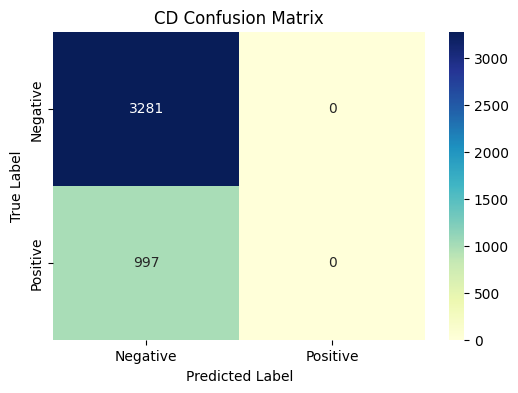

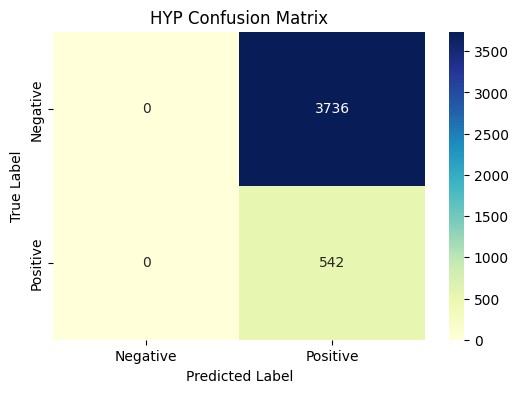

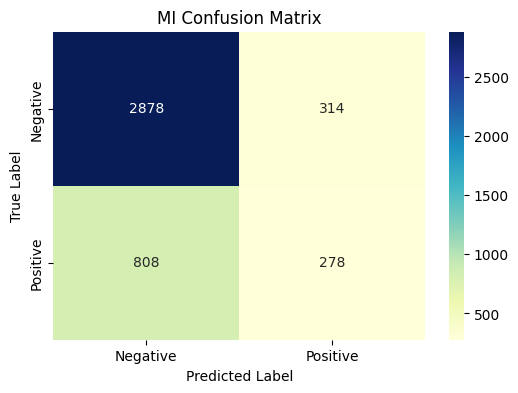

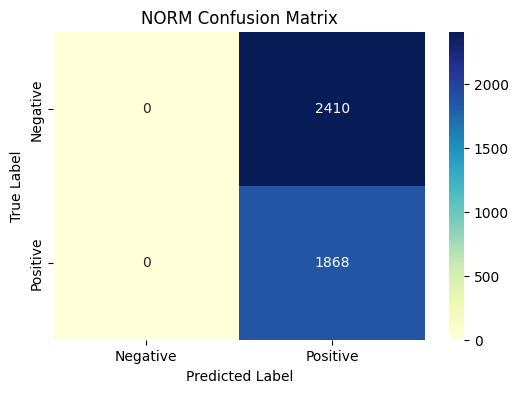

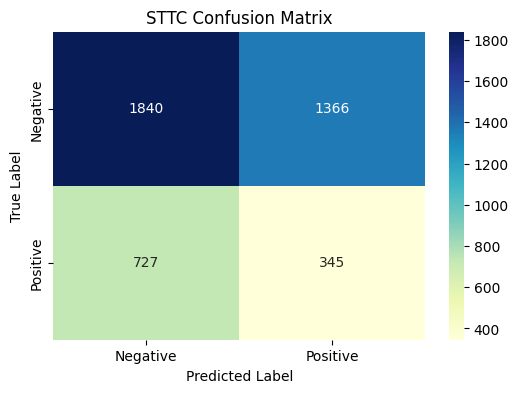

In [47]:
conf_matrix = show_confusion_matrix(y_test, y_hat, matrix_labels)